# Organize the Embeddings as a Tensor

**Questions**
1. Given the embedding of a cell, how well can we predict how the cell's embedding will move for a particular TF perturbation?
2. Given a perturbation `u` and a `TF` how well can we predict the perturbation?
3. Given the cell, can we tell which `TF`s it is most "sensitive" to?

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad # JP add this line
import os
import sys
import time
import umap

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# To get the single cell observations
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/DARPA_AI/in-silico-reprogramming/unperturbed"
FILE = "fibroblast.h5ad"
scAdata = sc.read_h5ad(os.path.join(DATAPATH, FILE))

# To get the Transcription Factors
humanTfdf = pd.read_csv('data/HumanTFs_v_1.01.csv') # JP this line is changed
humanTfdf.head()

# To get the list of files
data_path = "/scratch/indikar_root/indikar0/jpic/pb1k/geneformer"
h5ad_files = [f for f in os.listdir(data_path) if f.endswith(".h5ad")]
print(h5ad_files)
ncells = len(h5ad_files)
len(h5ad_files)

['CATCGCTCACCCTTGT_TSP14_Vasculature_CoronaryArteries_10X_1_1.h5ad', 'TGGATGTTCTCTCCGA_TSP4_Uterus_Endometrium_10X_1_1.h5ad', 'GCCGTGAAGGAAAGTG_TSP4_Uterus_Endometrium_10X_1_1.h5ad', 'TACCCACTCCGAGATT_TSP10_FAT_SCAT_10X_1_1.h5ad', 'B107813_E8_S288.homo.gencode.v30.ERCC.chrM.h5ad', 'GCATTAGGTTATTCCT_TSP10_FAT_SCAT_10X_1_1.h5ad', 'AGTGATCGTCTAGTGT_TSP8_Prostate_NA_10X_1_2.h5ad', 'GGCAGTCGTTGCTGAT_TSP14_Vasculature_AortaVeneCava_10X_1_1.h5ad', 'GTAACCATCGAACGGA_TSP4_Uterus_Endometrium_10X_1_1.h5ad', 'GGGCATCAGACTGGGT_TSP14_Thymus_NA_10X_2_1_5Prime.h5ad', 'GTAATCGGTCTTCAAG_TSP10_FAT_MAT_10X_1_1.h5ad', 'AGTACTGAGCCATTCA_TSP14_Fat_SCAT_10X_1_1.h5ad', 'ATTCCATAGTTTGGCT_TSP14_Vasculature_CoronaryArteries_10X_1_1.h5ad', 'ATTGGACCAAGGACTG_TSP14_Thymus_NA_10X_2_1_5Prime.h5ad', 'CTGGCAGCAGCCATTA_TSP14_Fat_SCAT_10X_1_1.h5ad', 'TCTCAGCAGACTCATC_TSP10_FAT_MAT_10X_1_1.h5ad', 'CCTCCTCTCCATGATG_TSP14_Bladder_NA_10X_1_1.h5ad', 'GCACTCTTCTTAACCT_TSP14_Thymus_NA_10X_2_1_5Prime.h5ad', 'CCTACGTAGAGGATGA_TSP1

67

In [3]:
scDfs, tfDf, uDf = None, None, None

# Build the dataframes
file_indices = [f[:-5] for f in h5ad_files]
scDfs = scAdata.obs.loc[file_indices]

# Load one file to build the dataframes with
adata = sc.read_h5ad(os.path.join(data_path, h5ad_files[0]))
TF_list = list(adata.obs['TF'].unique())
TF_list = [x for x in TF_list if isinstance(x, str)]
tfDf = humanTfdf[humanTfdf['Ensembl ID'].isin(TF_list)].drop(['Unnamed: 0'], axis=1)
TF_list = list(tfDf['Ensembl ID'].values)

U_list = list(adata.obs['U'].unique())
U_list.sort()

In [4]:
# embeddin dimension x single cells x number of TFs x perturbation sizes (10 + no perturbation)
X = np.zeros((512, ncells, 1637, 11))

In [5]:
TF_list, U_list = None, None
for filei, file in enumerate(h5ad_files):
    print(f"{filei/len(h5ad_files)}")
    adata = sc.read_h5ad(os.path.join(data_path, file))
    if TF_list is None:
        TF_list = list(adata.obs['TF'].unique())
        TF_list = [x for x in TF_list if isinstance(x, str)]
    if U_list is None:
        U_list = list(adata.obs['U'].unique())
        U_list.sort()
    for cellPerturbationi in range(adata.shape[0]):
        u = adata.obs['U'].iloc[cellPerturbationi]
        if u != 0:
            tf = adata.obs['TF'].iloc[cellPerturbationi]
            uIdx  = U_list.index(u)
            tfIdx = TF_list.index(tf)
            X[:, filei, tfIdx, uIdx] = adata.X[filei, :]
        else:
            uIdx  = U_list.index(u)
            for tfIdx in range(X.shape[2]):
                X[:, filei, tfIdx, uIdx] = adata.X[filei, :]
    

0.0
0.014925373134328358
0.029850746268656716
0.04477611940298507
0.05970149253731343
0.07462686567164178
0.08955223880597014
0.1044776119402985
0.11940298507462686
0.13432835820895522
0.14925373134328357
0.16417910447761194
0.1791044776119403
0.19402985074626866
0.208955223880597
0.22388059701492538
0.23880597014925373
0.2537313432835821
0.26865671641791045
0.2835820895522388
0.29850746268656714
0.31343283582089554
0.3283582089552239
0.34328358208955223
0.3582089552238806
0.373134328358209
0.3880597014925373
0.40298507462686567
0.417910447761194
0.43283582089552236
0.44776119402985076
0.4626865671641791
0.47761194029850745
0.4925373134328358
0.5074626865671642
0.5223880597014925
0.5373134328358209
0.5522388059701493
0.5671641791044776
0.582089552238806
0.5970149253731343
0.6119402985074627
0.6268656716417911
0.6417910447761194
0.6567164179104478
0.6716417910447762
0.6865671641791045
0.7014925373134329
0.7164179104477612
0.7313432835820896
0.746268656716418
0.7611940298507462
0.7761194

In [34]:
def direction_tensor(X, U_list):
    """X is coordiantes by single cell by TF by perturbation magnitude, and U_list is indices into the 4-th mode"""
    # Auth: Joshua Pickard
    #       jpic@umich.edu
    # Date: September 29, 2024
    init = U_list.index(0)
    V = X.copy()
    for sci in range(X.shape[1]):
        for TFi in range(X.shape[2]):
            for ptbi in range(X.shape[3]):
                V[:, sci, TFi, ptbi] -= V[:, sci, TFi, init]
    return V

V = direction_tensor(X, U_list)
V.shape

(512, 65, 1637, 11)

# Example Analysis

## UMAP of Positions

In [37]:
tdata = TensorData(X=X, frames=[None, scDfs, tfDf, U_list])
tdata.frames[3] = tdata.frames[3].rename(columns={
    'index':'U'
})
tdata.frames[0] = tdata.frames[0].rename(columns={
    'index':'embedding coordinates'
})

In [10]:
tdata_flat = tdata.unfold((512, int(np.prod(tdata.X.shape) / tdata.X.shape[0])))
tdata_flat.X.shape

(512, 1080420)

In [19]:
tdata_flat_reduced = tdata_flat[:, np.random.randint(0, tdata_flat.X.shape[1], 100000)]
tdata_flat_reduced.X.shape

(512, 100000)

In [20]:
# Step 1: Perform UMAP on adata.X
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
tdata_umap = reducer.fit_transform(tdata_flat_reduced.X.T)  # Ensure adata.X is dense (toarray())

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [21]:
# Step 2: Create a DataFrame for plotting
umap_df = pd.DataFrame(tdata_umap, columns=['UMAP1', 'UMAP2'])
tdata_flat_reduced.frames[1]['UMAP1'] = list(umap_df['UMAP1'].values)
tdata_flat_reduced.frames[1]['UMAP2'] = list(umap_df['UMAP2'].values)

/tmp/ipykernel_3026866/3677841002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata_flat_reduced.frames[1]['UMAP1'] = list(umap_df['UMAP1'].values)
/tmp/ipykernel_3026866/3677841002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata_flat_reduced.frames[1]['UMAP2'] = list(umap_df['UMAP2'].values)


In [22]:
tdata_flat_reduced.frames[1]

,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?,U,UMAP1,UMAP2
692348,Thymus,10X,TSP14,nan,4421.0,1494,fibroblast,fibroblast,True,stromal,...,"4a, two or more datasets predict it as a TF",Yimeng Yin,Arttu Jolma,Yes,NaN,$#ENSP00000468446#ENSG00000153896#ENST00000587...,True,1.00,2.008003,-11.291059
588887,Fat,10X,TSP10,MAT,27491.0,5187,fibroblast,Fibroblasts,True,stromal,...,"1a1, Direct HQ evidence",Jussi Taipale,Arttu Jolma,Yes,$#ENSG00000081059#GO:0001227#RNA polymerase II...,$#ENSP00000340347#ENSG00000081059#ENST00000342...,False,-0.50,11.444488,-5.297517
1043147,Vasculature,10X,TSP2,Aorta,12008.0,3116,fibroblast,fibroblast,True,stromal,...,"1a1, Direct HQ evidence",Arttu Jolma,Laura Campitelli,Yes,$#ENSG00000113658#GO:0003700#sequence-specific...,$#ENSP00000425749#ENSG00000113658#ENST00000507...,False,0.50,-4.130730,12.251952
73866,Lung,smartseq2,TSP1,Proximal,1013213.0,1879,alveolar fibroblast,alveolar fibroblast,True,stromal,...,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,Yes,$#ENSG00000107175#GO:0000982#RNA polymerase II...,$#ENSP00000342136#ENSG00000107175#ENST00000353...,False,-0.75,20.402596,-5.609494
779806,Mammary,10X,TSP4,nan,10999.0,2730,fibroblast of breast,Fibroblasts (Lipofibroblasts),True,stromal,...,"1a1, Direct HQ evidence",Pratyush Das,Sam Lambert,Yes,$#ENSG00000159917#GO:0003700#sequence-specific...,$#ENSP00000291182#ENSG00000159917#ENST00000291...,True,0.25,-5.364476,4.789143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690703,Thymus,10X,TSP14,nan,4421.0,1494,fibroblast,fibroblast,True,stromal,...,"1a1, Direct HQ evidence",Sam Lambert,Laura Campitelli,No,NaN,$#ENSP00000281523#ENSG00000151789#ENST00000281...,False,-0.50,1.930261,-11.345815
192879,Fat,10X,TSP10,MAT,14086.0,3175,fibroblast,Fibroblasts,True,stromal,...,"1a1, Direct HQ evidence",Pratyush Das,Sam Lambert,Yes,$#ENSG00000131668#GO:0001228#RNA polymerase II...,$#ENSP00000253968#ENSG00000131668#ENST00000253...,False,0.25,14.269832,-9.472260
455308,Thymus,10X,TSP14,nan,13941.0,3788,fibroblast,fibroblast,True,stromal,...,"1a1, Direct HQ evidence",Pratyush Das,Yimeng Yin,Yes,$#ENSG00000147118#GO:0003700#sequence-specific...,$#ENSP00000366142#ENSG00000147118#ENST00000376...,True,0.75,-6.641618,20.360979
237909,Thymus,10X,TSP14,nan,19999.0,4852,fibroblast,fibroblast,True,stromal,...,"1a1, Direct HQ evidence",Laura Campitelli,Pratyush Das,Yes,NaN,$#ENSP00000389381#ENSG00000230797#ENST00000429...,False,-0.75,6.558501,20.214611


In [23]:
tdata_flat_reduced.frames[1]['index'] = tdata_flat_reduced.frames[1].index

/tmp/ipykernel_3026866/228402726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata_flat_reduced.frames[1]['index'] = tdata_flat_reduced.frames[1].index


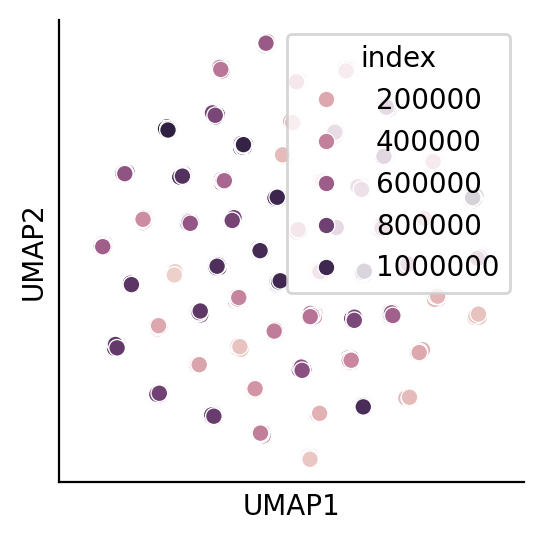

In [24]:
plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(
    data = tdata_flat_reduced.frames[1],
    x = 'UMAP1',
    y = 'UMAP2',
    hue='index'
)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
sns.despine()
plt.show()

## UMAP of Velocities

In [31]:
vtdata = TensorData(X=V, frames=[None, scDfs, tfDf, U_list])
vtdata.frames[3] = vtdata.frames[3].rename(columns={
    'index':'U'
})
vtdata.frames[0] = vtdata.frames[0].rename(columns={
    'index':'embedding coordinates'
})
vtdata_flat = vtdata.unfold((512, int(np.prod(vtdata.X.shape) / vtdata.X.shape[0])))
vtdata_flat.X.shape

vtdata_flat_reduced = vtdata_flat[:, np.random.randint(0, vtdata_flat.X.shape[1], 100000)]
vtdata_flat_reduced.X.shape

(512, 100000)

In [32]:
# Step 1: Perform UMAP on adata.X
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
vtdata_umap = reducer.fit_transform(vtdata_flat_reduced.X.T)  # Ensure adata.X is dense (toarray())

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [33]:
# Step 2: Create a DataFrame for plotting
umap_df = pd.DataFrame(vtdata_umap, columns=['UMAP1', 'UMAP2'])
vtdata_flat_reduced.frames[1]['UMAP1'] = list(umap_df['UMAP1'].values)
vtdata_flat_reduced.frames[1]['UMAP2'] = list(umap_df['UMAP2'].values)

/tmp/ipykernel_3026866/925744343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vtdata_flat_reduced.frames[1]['UMAP1'] = list(umap_df['UMAP1'].values)
/tmp/ipykernel_3026866/925744343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vtdata_flat_reduced.frames[1]['UMAP2'] = list(umap_df['UMAP2'].values)


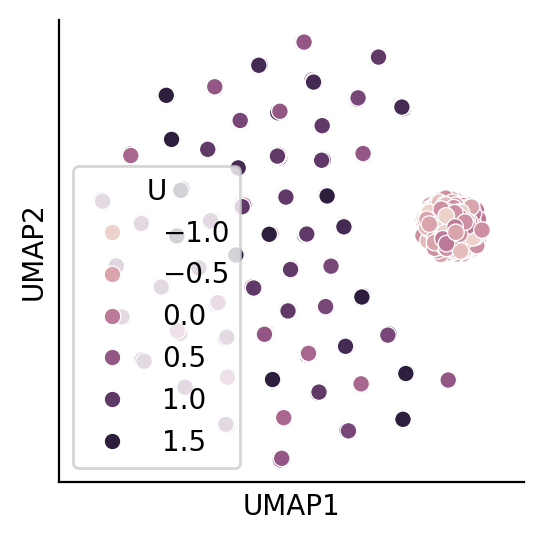

In [34]:
plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(
    data = vtdata_flat_reduced.frames[1],
    x = 'UMAP1',
    y = 'UMAP2',
    hue='U'
)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
sns.despine()
plt.show()

## Single Cells

In [53]:
sctdata = tdata[:, :1, :, :]
sctdata.frames[2]['TF Name'] = sctdata.frames[2]['HGNC symbol']
sctdata_flat = sctdata.unfold((512, int(np.prod(sctdata.shape)/512)))
sctdata_flat.shape

(512, 18007)

In [54]:
sctdata_flat.frames[1]

,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?,TF Name,U
0,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,TFAP2A,-1.00
1,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,TFAP2A,-0.75
2,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,TFAP2A,-0.50
3,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,TFAP2A,-0.25
4,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,TFAP2A,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18002,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,XPA,0.50
18003,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,XPA,0.75
18004,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,XPA,1.00
18005,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,XPA,1.25


In [56]:
# Step 1: Perform UMAP on adata.X
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
scdata_umap = reducer.fit_transform(sctdata_flat.X.T)  # Ensure adata.X is dense (toarray())

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [57]:
# Step 2: Create a DataFrame for plotting
umap_df = pd.DataFrame(scdata_umap, columns=['UMAP1', 'UMAP2'])
sctdata_flat.frames[1]['UMAP1'] = list(umap_df['UMAP1'].values)
sctdata_flat.frames[1]['UMAP2'] = list(umap_df['UMAP2'].values)

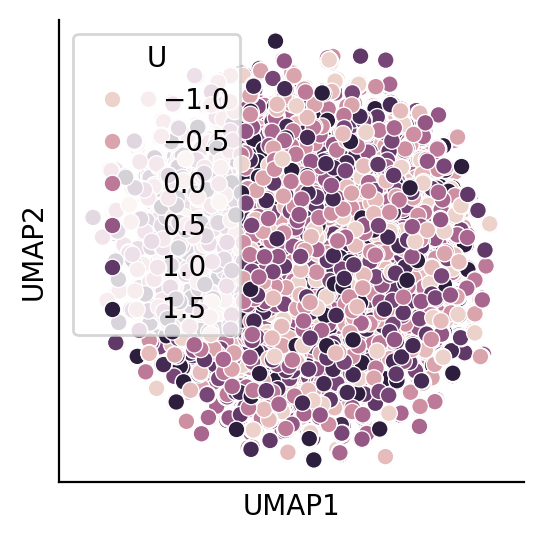

In [58]:
plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(
    data = sctdata_flat.frames[1],
    x = 'UMAP1',
    y = 'UMAP2',
    hue='U'
)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
sns.despine()
plt.show()

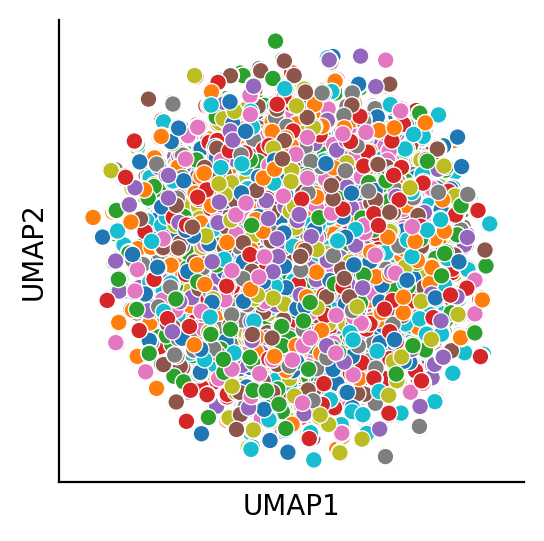

In [61]:
plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(
    data = sctdata_flat.frames[1],
    x = 'UMAP1',
    y = 'UMAP2',
    hue='TF Name',
    legend=False,
    palette='tab10'
)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
sns.despine()
plt.show()

## UMAP

In [19]:
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
help(reducer.fit_transform)

Help on method fit_transform in module umap.umap_:

fit_transform(X, y=None, force_all_finite=True) method of umap.umap_.UMAP instance
    Fit X into an embedded space and return that transformed
    output.
    
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        If the metric is 'precomputed' X must be a square distance
        matrix. Otherwise it contains a sample per row.
    
    y : array, shape (n_samples)
        A target array for supervised dimension reduction. How this is
        handled is determined by parameters UMAP was instantiated with.
        The relevant attributes are ``target_metric`` and
        ``target_metric_kwds``.
    
    force_all_finite : Whether to raise an error on np.inf, np.nan, pd.NA in array.
        The possibilities are: - True: Force all values of array to be finite.
                               - False: accepts np.inf, np.nan, pd.NA in array.
                               - 'allow-nan'

In [23]:
def mode_umaps(tdata, components=None, random_state=0):
    """This function computes the UMAP coordiantes of each mode and saves the singular vectors to the .frames of each mode"""
    # Auth: Joshua Pickard
    #       jpic@umich.edu
    # Date: October 1, 2024
    if components is None:
        components = [2 for i in range(len(tdata.shape))]
    if isinstance(components, int):
        c = components
        components = [c for i in range(len(tdata.shape))]

    for mode in range(len(tdata.shape)):
        tdata_mode_unfold = tdata.unfold_mode(mode=mode)
        print(f"{tdata_mode_unfold.shape=}")

        reducer = umap.UMAP(n_components=components[mode], random_state=random_state)  # Set to 2D output
        scdata_umap = reducer.fit_transform(tdata_mode_unfold.X)  # Ensure adata.X is dense (toarray())
        print(f"{scdata_umap.shape=}")
        print(f"{tdata.frames[mode].shape=}")
        for i in range(components[mode]):
            tdata.frames[mode]['UMAP' + str(i)] = scdata_umap[:,i]
    return tdata

In [24]:
tdata = mode_umaps(tdata)

tdata_mode_unfold.shape=(512, 1206469)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


scdata_umap.shape=(512, 2)
tdata.frames[mode].shape=(512, 6)
tdata_mode_unfold.shape=(67, 9219584)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


scdata_umap.shape=(67, 2)
tdata.frames[mode].shape=(67, 16)
tdata_mode_unfold.shape=(1637, 377344)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


scdata_umap.shape=(1637, 2)
tdata.frames[mode].shape=(1637, 33)
tdata_mode_unfold.shape=(11, 56155648)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


scdata_umap.shape=(11, 2)
tdata.frames[mode].shape=(11, 6)


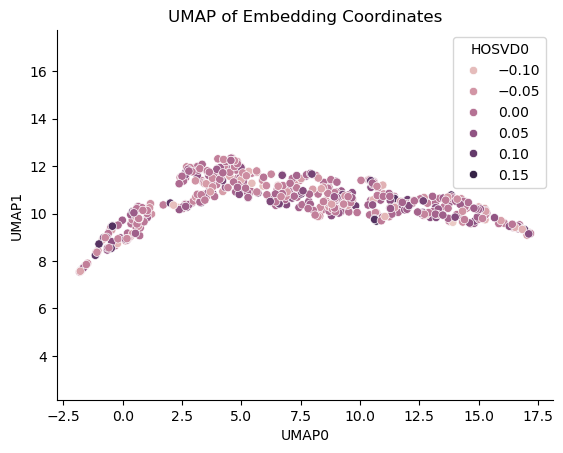

In [31]:
sns.scatterplot(
    data = tdata.frames[0],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'HOSVD0',
)
plt.axis('equal')
plt.title('UMAP of Embedding Coordinates')
sns.despine()

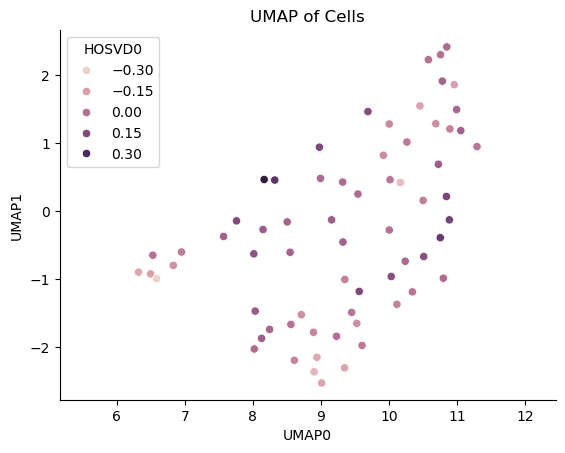

In [32]:
sns.scatterplot(
    data = tdata.frames[1],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'HOSVD0',
)
plt.axis('equal')
plt.title('UMAP of Cells')
sns.despine()

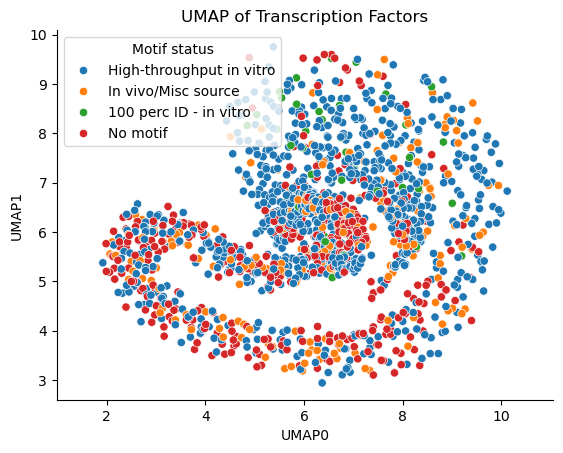

In [38]:
sns.scatterplot(
    data = tdata.frames[2],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'Motif status',
)
plt.axis('equal')
plt.title('UMAP of Transcription Factors')
sns.despine()

In [36]:
tdata.frames[2].columns

Index(['Ensembl ID', 'HGNC symbol', 'DBD', 'Is TF?', 'TF assessment',
       'Binding mode', 'Motif status', 'Final Notes', 'Final Comments',
       'Interpro ID(s)', 'EntrezGene ID', 'EntrezGene Description', 'PDB ID',
       'TF tested by HT-SELEX?', 'TF tested by PBM?',
       'Conditional Binding Requirements ', 'Original Comments',
       'Vaquerizas 2009 classification', 'CisBP considers it a TF?',
       'TFCat classification', 'Is a GO TF?', 'Initial assessment ',
       'Curator 1', 'Curator 2', 'TFclass considers it a TF? ', 'Go Evidence',
       'Pfam Domains (By ENSP ID)', 'Is C2H2 ZF(KRAB)?', 'HOSVD0', 'HOSVD1',
       'HOSVD2', 'HOSVD3', 'HOSVD4', 'UMAP0', 'UMAP1'],
      dtype='object')

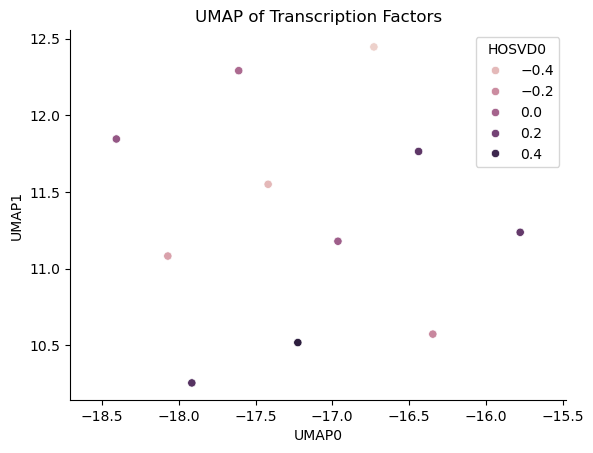

In [34]:
sns.scatterplot(
    data = tdata.frames[3],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'HOSVD0',
)
plt.axis('equal')
plt.title('UMAP of Transcription Factors')
sns.despine()

## HOSVD

In [6]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker

import time

from scipy.sparse.linalg import svds

import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
tdata = TensorData(X=X, frames=[None, scDfs, tfDf, U_list])
tdata.frames[3] = tdata.frames[3].rename(columns={
    'index':'U'
})
tdata.frames[0] = tdata.frames[0].rename(columns={
    'index':'embedding coordinates'
})

In [10]:
def hosvd(tdata, ranks=None):
    """This function computes the HOSVD and saves the singular vectors to the .frames of each mode"""
    # Auth: Joshua Pickard
    #       jpic@umich.edu
    # Date: October 1, 2024
    if ranks is None:
        ranks = [3 for i in range(len(tdata.shape))]
    if isinstance(ranks, int):
        r = ranks
        ranks = [r for i in range(len(tdata.shape))]

    for mode in range(len(tdata.shape)):
        tdata_mode_unfold = tdata.unfold_mode(mode=mode)
        print(f"{tdata_mode_unfold.shape=}")
        u_modes, _, _ = svds(tdata_mode_unfold.X, k=ranks[mode])
        print(f"{u_modes.shape=}")
        print(f"{tdata.frames[mode].shape=}")
        for i in range(ranks[mode]):
            tdata.frames[mode]['HOSVD' + str(i)] = u_modes[:,i]
    return tdata

In [11]:
start_time = time.time()
tdata = hosvd(tdata, ranks=5)
print(time.time() - start_time)

tdata_mode_unfold.shape=(512, 1206469)
u_modes.shape=(512, 5)
tdata.frames[mode].shape=(512, 1)
tdata_mode_unfold.shape=(67, 9219584)
u_modes.shape=(67, 5)
tdata.frames[mode].shape=(67, 11)
tdata_mode_unfold.shape=(1637, 377344)
u_modes.shape=(1637, 5)
tdata.frames[mode].shape=(1637, 28)
tdata_mode_unfold.shape=(11, 56155648)
u_modes.shape=(11, 5)
tdata.frames[mode].shape=(11, 1)
177.62935042381287


In [13]:
tdata.frames[1]

,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,HOSVD0,HOSVD1,HOSVD2,HOSVD3,HOSVD4
CATCGCTCACCCTTGT_TSP14_Vasculature_CoronaryArteries_10X_1_1,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,male,0.157142,-0.049582,0.004486,0.019309,-0.123390
TGGATGTTCTCTCCGA_TSP4_Uterus_Endometrium_10X_1_1,Uterus,10X,TSP4,Endometrium,9452.0,3152,fibroblast,Endometrial stromal fibbroblast,True,stromal,female,0.373858,-0.050741,0.032993,-0.044360,-0.118086
GCCGTGAAGGAAAGTG_TSP4_Uterus_Endometrium_10X_1_1,Uterus,10X,TSP4,Endometrium,5431.0,1681,fibroblast,Uterine fibroblast,True,stromal,female,0.134933,0.041979,-0.001117,-0.051364,-0.120297
TACCCACTCCGAGATT_TSP10_FAT_SCAT_10X_1_1,Fat,10X,TSP10,SCAT,6618.0,1893,fibroblast,Fibroblasts,True,stromal,male,-0.169711,0.170814,0.060189,-0.076518,-0.119102
B107813_E8_S288.homo.gencode.v30.ERCC.chrM,Lung,smartseq2,TSP1,Proximal,1013213.0,1879,alveolar fibroblast,alveolar fibroblast,True,stromal,female,0.017524,0.004343,0.239421,0.491514,-0.134443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCTATTCAAGATAG_TSP2_Thymus_NA_10X_1_2,Thymus,10X,TSP2,nan,7462.0,2418,fibroblast,fibroblast,True,stromal,female,-0.102989,0.088081,0.058445,-0.071053,-0.119978
CGAACATAGCGACGTA_TSP14_Thymus_NA_10X_2_1_5Prime,Thymus,10X,TSP14,nan,11873.0,3442,fibroblast,fibroblast,True,stromal,male,-0.303070,-0.279880,0.110319,-0.063680,-0.118725
CTCAGAATCAGTCTTT_TSP1_bladder_1,Bladder,10X,TSP1,nan,8153.0,2290,fibroblast,fibroblast,True,stromal,female,-0.055036,0.068320,-0.027202,-0.061099,-0.121657
TTTCAGTTCCGGTAGC_TSP2_Vasculature_Aorta_10X_1_2,Vasculature,10X,TSP2,Aorta,11151.0,3088,fibroblast,fibroblast,True,stromal,female,0.054680,-0.038477,-0.025194,-0.071357,-0.120448


In [55]:
tdata_cords = tdata.unfold_mode(mode=0)
tdata_cells = tdata.unfold_mode(mode=1)
tdata_tfss  = tdata.unfold_mode(mode=2)
tdata_us    = tdata.unfold_mode(mode=3)
print(f"{tdata_cords.shape=}")
print(f"{tdata_cells.shape=}")
print(f"{tdata_tfss.shape=}")
print(f"{tdata_us.shape=}")

tdata_cords.shape=(512, 1170455)
tdata_cells.shape=(65, 9219584)
tdata_tfss .shape=(1637, 366080)
tdata_us   .shape=(11, 54479360)


In [57]:
start_time = time.time()
u_cords, _, _ = svds(tdata_cords.X, k=3)
u_cells, _, _ = svds(tdata_cells.X, k=3)
u_tfss,  _, _ = svds(tdata_tfss.X, k=3)
u_us,    _, _ = svds(tdata_us.X, k=3)
print(time.time() - start_time)

96.37106704711914


In [60]:
tdata.frames[0]['HOSVD1'] = u_cords[:,0]
tdata.frames[0]['HOSVD2'] = u_cords[:,1]
tdata.frames[0]['HOSVD3'] = u_cords[:,2]
tdata.frames[1]['HOSVD1'] = u_cells[:,0]
tdata.frames[1]['HOSVD2'] = u_cells[:,1]
tdata.frames[1]['HOSVD3'] = u_cells[:,2]
tdata.frames[2]['HOSVD1'] = u_tfss[:,0]
tdata.frames[2]['HOSVD2'] = u_tfss[:,1]
tdata.frames[2]['HOSVD3'] = u_tfss[:,2]
tdata.frames[3]['HOSVD1'] = u_us[:,0]
tdata.frames[3]['HOSVD2'] = u_us[:,1]
tdata.frames[3]['HOSVD3'] = u_us[:,2]


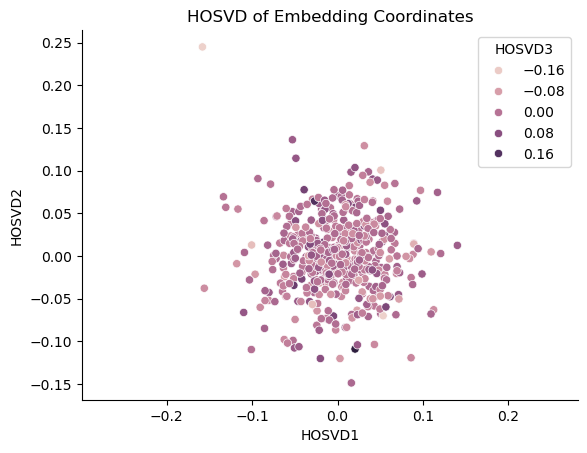

In [14]:
sns.scatterplot(
    data = tdata.frames[0],
    x = 'HOSVD1',
    y = 'HOSVD2',
    hue = 'HOSVD3',
)
plt.axis('equal')
plt.title('HOSVD of Embedding Coordinates')
sns.despine()

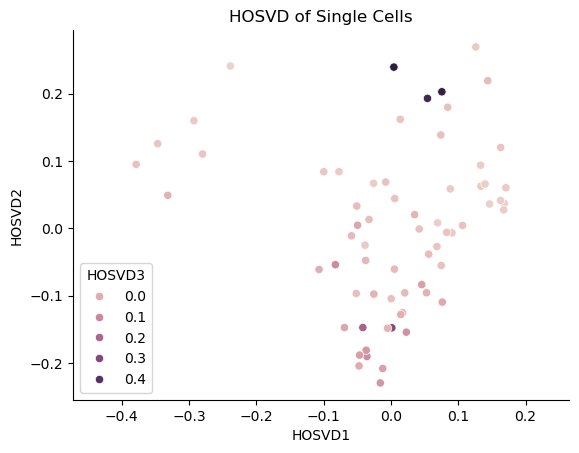

In [15]:
sns.scatterplot(
    data = tdata.frames[1],
    x = 'HOSVD1',
    y = 'HOSVD2',
    hue = 'HOSVD3',
)
plt.axis('equal')
plt.title('HOSVD of Single Cells')
sns.despine()

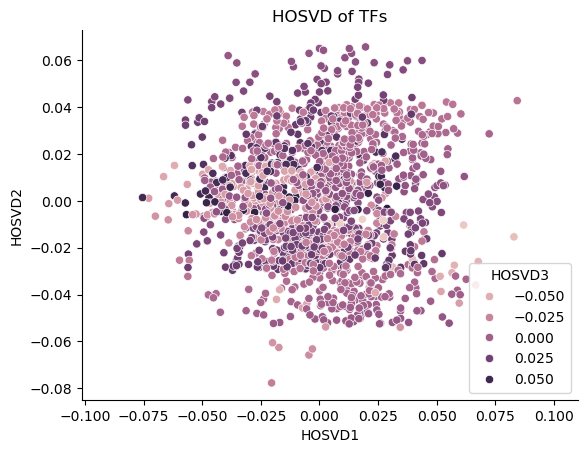

In [16]:
sns.scatterplot(
    data = tdata.frames[2],
    x = 'HOSVD1',
    y = 'HOSVD2',
    hue = 'HOSVD3',
)
plt.axis('equal')
plt.title('HOSVD of TFs')
sns.despine()

In [73]:
tdata.frames[2]

,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,Interpro ID(s),...,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?,HOSVD1,HOSVD2,HOSVD3
0,ENSG00000137203,TFAP2A,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,IPR008121;IPR013854,...,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,-0.016851,-0.026466,-0.024716
1,ENSG00000008196,TFAP2B,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,IPR008122;IPR013854,...,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000008196#GO:0000981#sequence-specific...,$#ENSP00000377265#ENSG00000008196#ENST00000393...,False,-0.036565,-0.056467,-0.024716
2,ENSG00000087510,TFAP2C,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,IPR008123;IPR013854,...,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000087510#GO:0001077#RNA polymerase II...,$#ENSP00000201031#ENSG00000087510#ENST00000201...,False,-0.020906,0.011481,-0.024716
3,ENSG00000008197,TFAP2D,AP-2,Yes,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,Binds the same GCCTGAGGC sequence as the other...,IPR013854;,...,"2a1, Lower confidence direct evidence",Arttu Jolma,Sam Lambert,Yes,$#ENSG00000008197#GO:0000981#sequence-specific...,$#ENSP00000008391#ENSG00000008197#ENST00000008...,False,0.019558,-0.002044,-0.024716
4,ENSG00000116819,TFAP2E,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,IPR013854;,...,"1a1, Direct HQ evidence",Sam Lambert,Laura Campitelli,Yes,$#ENSG00000116819#GO:0000981#sequence-specific...,$#ENSP00000362332#ENSG00000116819#ENST00000373...,False,-0.005251,0.006248,-0.024716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,ENSG00000151500,THYN1,Unknown,Yes,Likely to be sequence specific TF,Low specificity DNA-binding protein,No motif,NaN,Binds DNA in the crystal structure (PDB: 5J3E)...,NaN,...,New proteins added based on PDB entry,NaN,NaN,No,NaN,NaN,False,0.031482,-0.006031,-0.024716
2644,ENSG00000144747,TMF1,Unknown,Yes,Likely to be sequence specific TF,Monomer or homomultimer,No motif,NaN,Bacterially-expressed protein binds specifical...,IPR022091;IPR022092,...,"5a, one of the source datasets predicts is as ...",Arttu Jolma,Sam Lambert,No,NaN,$##ENSG00000144747##Other#,False,0.030781,0.030795,-0.024716
2656,ENSG00000197579,TOPORS,Unknown,Yes,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,NaN,IPR001841;IPR017907;IPR018957,...,"2a1, Lower confidence direct evidence",Pratyush Das,Sam Lambert,No,NaN,$#ENSP00000353735#ENSG00000197579#ENST00000360...,False,0.027974,-0.004858,-0.024716
2698,ENSG00000102804,TSC22D1,Unknown,Yes,Likely to be sequence specific TF,Monomer or homomultimer,No motif,NaN,TSC22D1 appears to homo- and heterodimerize wi...,IPR000580;,...,"4a, two or more datasets predict it as a TF",Sam Lambert,Jussi Taipale,Yes,$#ENSG00000102804#GO:0003700#sequence-specific...,$#ENSP00000261489#ENSG00000102804#ENST00000261...,False,0.042347,-0.009662,-0.024716


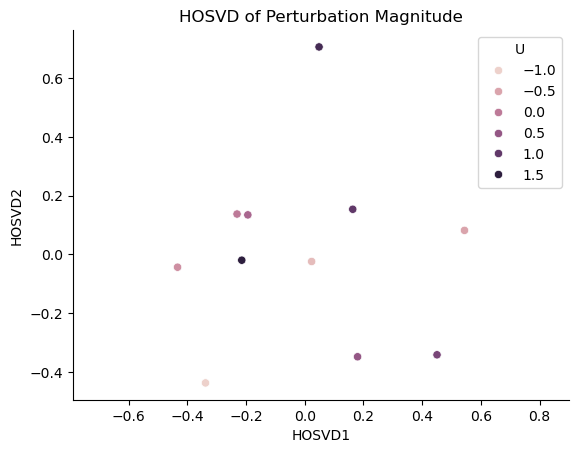

In [17]:
sns.scatterplot(
    data = tdata.frames[3],
    x = 'HOSVD1',
    y = 'HOSVD2',
    hue = 'U',
)
plt.axis('equal')
plt.title('HOSVD of Perturbation Magnitude')
sns.despine()

In [70]:
tdata.frames[3]

,U,HOSVD1,HOSVD2,HOSVD3
0,-1.00,0.024517,-0.185880,-0.301511
1,-0.75,0.261404,-0.111048,-0.301511
2,-0.50,-0.094184,-0.223388,-0.301511
3,-0.25,0.428359,-0.058306,-0.301511
4,0.00,-0.024280,-0.201300,-0.301511
5,0.25,-0.161722,-0.244734,-0.301511
6,0.50,-0.110070,-0.228416,-0.301511
7,0.75,0.120946,-0.155410,-0.301511
8,1.00,-0.698450,0.295700,-0.301511
9,1.25,0.414193,0.647203,-0.301511


In [2]:
core_tensor, factors = tucker(tdata.X, rank=3, n_iter_max=10)

NameError: name 'tdata' is not defined

In [18]:
T = np.random.rand(1000,100,40, 10)

core_tensor, factors = tucker(T, rank=10, n_iter_max=10)


/home/jpic/.local/lib/python3.11/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 4. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [19]:
factors[0].shape

(1000, 10)

In [21]:
core_tensor.shape

(10, 10, 10, 10)

In [23]:
# Step 1: Perform UMAP on adata.X
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
scdata_umap = reducer.fit_transform(factors[0])  # Ensure adata.X is dense (toarray())

/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [26]:
umap_df = pd.DataFrame(scdata_umap, columns=['UMAP1', 'UMAP2'])

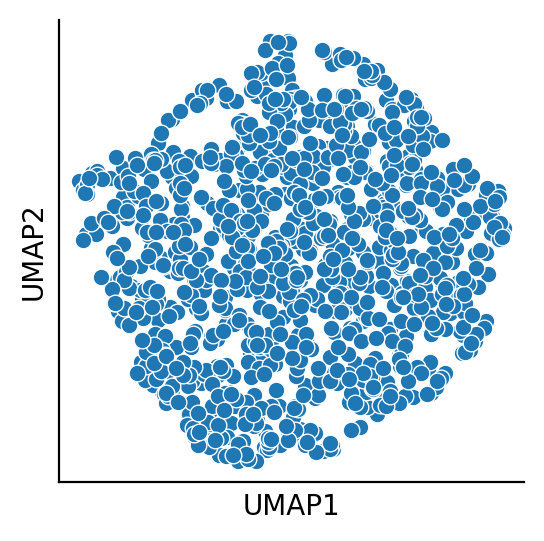

In [27]:
plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(
    data = umap_df,
    x = 'UMAP1',
    y = 'UMAP2',
#    hue='TF Name',
#    legend=False,
#    palette='tab10'
)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
sns.despine()
plt.show()

## HOSVD and UMAPs of the velcotiy tensor

In [40]:
def direction_tensor(X, U_list):
    """X is coordiantes by single cell by TF by perturbation magnitude, and U_list is indices into the 4-th mode"""
    # Auth: Joshua Pickard
    #       jpic@umich.edu
    # Date: September 29, 2024
    init = U_list.index(0)
    V = X.copy()
    for sci in range(X.shape[1]):
        for TFi in range(X.shape[2]):
            for ptbi in range(X.shape[3]):
                V[:, sci, TFi, ptbi] -= V[:, sci, TFi, init]
    return V

V = direction_tensor(X, U_list)
V.shape

(512, 67, 1637, 11)

In [41]:
vtdata = TensorData(X=V, frames=[None, scDfs, tfDf, U_list])
vtdata.frames[3] = vtdata.frames[3].rename(columns={
    'index':'U'
})
vtdata.frames[0] = vtdata.frames[0].rename(columns={
    'index':'embedding coordinates'
})
vtdata.shape

(512, 67, 1637, 11)

In [42]:
start_time = time.time()
vtdata = hosvd(vtdata, ranks=5)
print(time.time() - start_time)

tdata_mode_unfold.shape=(512, 1206469)
u_modes.shape=(512, 5)
tdata.frames[mode].shape=(512, 1)
tdata_mode_unfold.shape=(67, 9219584)
u_modes.shape=(67, 5)
tdata.frames[mode].shape=(67, 18)
tdata_mode_unfold.shape=(1637, 377344)
u_modes.shape=(1637, 5)
tdata.frames[mode].shape=(1637, 35)
tdata_mode_unfold.shape=(11, 56155648)
u_modes.shape=(11, 5)
tdata.frames[mode].shape=(11, 1)
182.8398356437683


In [44]:
start_time = time.time()
vtdata = mode_umaps(vtdata, components=2)
print(time.time() - start_time)

tdata_mode_unfold.shape=(512, 1206469)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


scdata_umap.shape=(512, 2)
tdata.frames[mode].shape=(512, 6)
tdata_mode_unfold.shape=(67, 9219584)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


scdata_umap.shape=(67, 2)
tdata.frames[mode].shape=(67, 18)
tdata_mode_unfold.shape=(1637, 377344)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


scdata_umap.shape=(1637, 2)
tdata.frames[mode].shape=(1637, 35)
tdata_mode_unfold.shape=(11, 56155648)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


scdata_umap.shape=(11, 2)
tdata.frames[mode].shape=(11, 6)
482.0375883579254


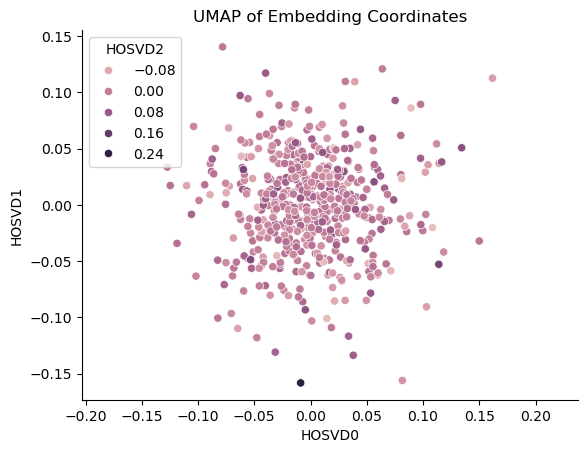

In [45]:
sns.scatterplot(
    data = tdata.frames[0],
    x = 'HOSVD0',
    y = 'HOSVD1',
    hue = 'HOSVD2',
)
plt.axis('equal')
plt.title('HOSVD of Embedding Coordinates')
sns.despine()

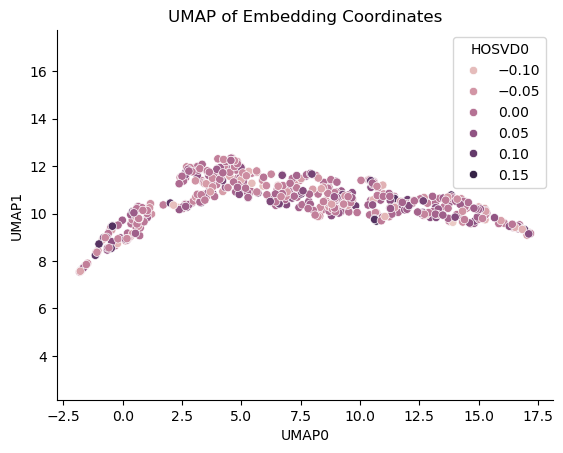

In [46]:
sns.scatterplot(
    data = tdata.frames[0],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'HOSVD0',
)
plt.axis('equal')
plt.title('UMAP of Embedding Coordinates')
sns.despine()

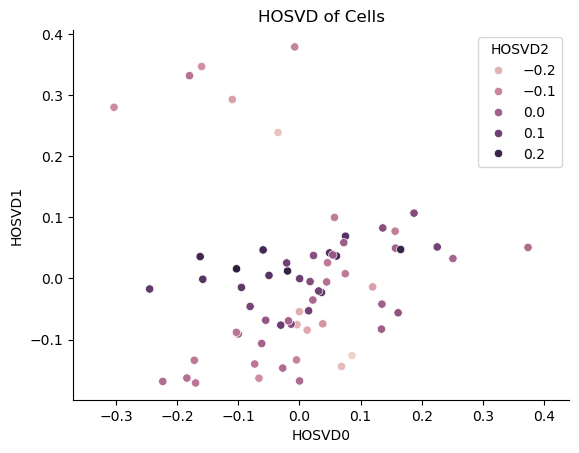

In [47]:
sns.scatterplot(
    data = tdata.frames[1],
    x = 'HOSVD0',
    y = 'HOSVD1',
    hue = 'HOSVD2',
)
plt.axis('equal')
plt.title('HOSVD of Cells')
sns.despine()

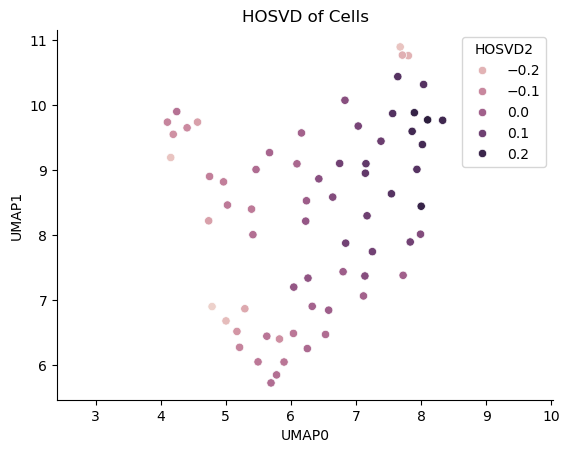

In [48]:
sns.scatterplot(
    data = tdata.frames[1],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'HOSVD2',
)
plt.axis('equal')
plt.title('HOSVD of Cells')
sns.despine()

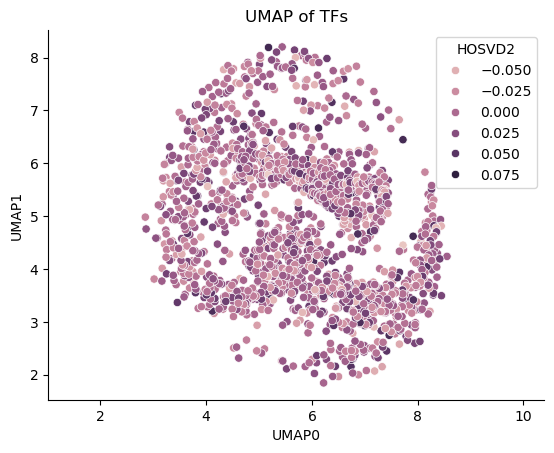

In [51]:
sns.scatterplot(
    data = tdata.frames[2],
    x = 'UMAP0',
    y = 'UMAP1',
    hue = 'HOSVD2',
)
plt.axis('equal')
plt.title('UMAP of TFs')
sns.despine()

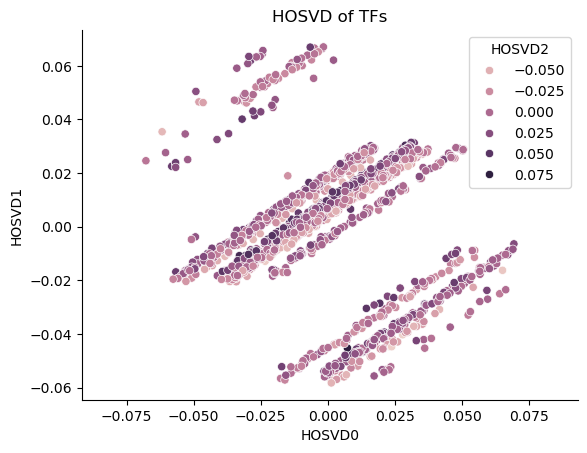

In [50]:
sns.scatterplot(
    data = tdata.frames[2],
    x = 'HOSVD0',
    y = 'HOSVD1',
    hue = 'HOSVD2',
)
plt.axis('equal')
plt.title('HOSVD of TFs')
sns.despine()

# Tensor Data Class

In [8]:
class TensorData:
    def __init__(self, X: np.ndarray, frames: list):
        """
        Initialize the TensorData object.

        Args:
        X (np.ndarray): A tensor of arbitrary size.
        frames (list): A list of Pandas DataFrames, one for each mode of the tensor.
                       The length of the list should match the number of modes of the tensor.
        """
        # Auth: Joshua Pickard
        #       jpic@umich.edu
        # Date: September 30, 2024
        self.X = X
        self.modes = X.ndim  # Number of modes of the tensor
        self.frames = frames
        
        # Process frames: If a frame is None or a list, convert it to a DataFrame
        for framei, frame in enumerate(self.frames):
            if isinstance(frame, list):
                self.frames[framei] = pd.DataFrame({'index': frame})
            elif frame is None:
                self.frames[framei] = pd.DataFrame({'index': [i for i in range(self.X.shape[framei])]})
        
        # Ensure that the number of dataframes matches the tensor modes
        if len(self.frames) != self.modes:
            raise ValueError(f"Expected {self.modes} dataframes, but got {len(frames)}.")

    def __repr__(self):
        return f"TensorData object with tensor of shape {self.X.shape} and {len(self.frames)} frames."

    @property
    def shape(self):
        """
        Return the shape of the tensor.
        """
        return self.X.shape

    def __getitem__(self, indices):
        """
        Index the tensor and associated dataframes.

        Args:
        indices (tuple): A tuple of indices for each mode of the tensor. These can be
                         integers, slices, or lists of indices.

        Returns:
        TensorData: A new TensorData object with the subsetted tensor and dataframes.
        """
        # Auth: Joshua Pickard
        #       jpic@umich.edu
        # Date: September 30, 2024
        # Ensure the correct number of indices are provided
        if len(indices) != self.modes:
            raise IndexError(f"Expected {self.modes} indices, but got {len(indices)}.")
        
        # Subset the tensor using the provided indices
        subset_X = self.X[indices]
        
        # Adjust the number of modes after slicing
        new_modes = subset_X.ndim
        
        # Adjust frames: Only keep frames for modes that were not reduced to single values
        subset_frames = []
        for mode, idx in enumerate(indices):
            if isinstance(idx, int):
                # If it's an integer, the dimension is reduced and we skip adding the frame
                continue
            else:
                # Use the slice, list, or range as provided for slicing the dataframe
                subset_frames.append(self.frames[mode].iloc[idx])
        
        # Handle the case when new_modes is reduced to zero (for scalars)
        if new_modes == 0:
            subset_frames = []
        
        # Return a new TensorData object with the subsetted tensor and dataframes
        return TensorData(X=subset_X, frames=subset_frames)

    def transpose(self, new_order):
        """
        Transpose the modes of the tensor and reorder the associated dataframes.
    
        Args:
        new_order (tuple or list): The desired order of the modes after transposition. 
                                   It should be a permutation of the current mode indices.
    
        Returns:
        TensorData: A new TensorData object with transposed tensor and reordered dataframes.
        """
        # Auth: Joshua Pickard
        #       jpic@umich.edu
        # Date: September 30, 2024
        if len(new_order) != self.modes:
            raise ValueError(f"Expected a permutation of {self.modes} modes, but got {len(new_order)}.")
        
        # Transpose the tensor according to the new mode order
        transposed_X = self.X.transpose(new_order)
        
        # Reorder the dataframes according to the new mode order
        transposed_frames = [self.frames[i] for i in new_order]
        
        return TensorData(X=transposed_X, frames=transposed_frames)

    def unfold_mode(self, mode=0):
        # Auth: Joshua Pickard
        #       jpic@umich.edu
        # Date: October 1, 2024
        
        # Step 1: Transpose the tensor to bring the specified mode to the front
        # Generate the transpose order: move 'mode' to the front, and leave the rest in their current order
        transpose_order = [mode] + [i for i in range(len(self.X.shape)) if i != mode]
        
        # Apply the transposition to both the tensor data and the associated metadata frames
        tdata_perm = self.transpose(transpose_order)
        
        # Step 2: Unfold the tensor by reshaping it
        # The new shape will have the first dimension corresponding to the selected mode
        # The second dimension will be the product of the remaining dimensions
        new_shape = (tdata_perm.X.shape[0], int(np.prod(tdata_perm.X.shape[1:])))
        
        # Perform unfolding
        unfolded_tdata = tdata_perm.unfold(new_shape)
        
        return unfolded_tdata

    
    def unfold(self, new_shape):
        # Auth: Joshua Pickard
        #       jpic@umich.edu
        # Date: September 30, 2024
        if np.prod(self.X.shape) != np.prod(new_shape):
            raise ValueError("Reshape/unfold operation must maintain the same number of elements.")
        
        # Reshape the tensor
        reshaped_X = self.X.reshape(new_shape)

        merge_frames = []
        keep_frames = []
        for mode in range(len(self.X.shape)):
            if mode < len(new_shape) and self.X.shape[mode] == new_shape[mode]:
                keep_frames.append(self.frames[mode])
            else:
                merge_frames.append(self.frames[mode])
        merged_df = merge_frames[0]
        for df in merge_frames[1:]:
            merged_df = pd.merge(merged_df, df, how='cross')
        keep_frames.append(merged_df)
        return TensorData(X=reshaped_X, frames=keep_frames)

    def subset(self, mode: int, condition: dict):
        """
        Subset the tensor and corresponding metadata based on a condition applied to a specific mode.
    
        Args:
            mode (int): The mode of the tensor on which to apply the subsetting.
            condition (dict): A dictionary where keys are column names in the metadata DataFrame,
                              and values are the corresponding values to filter by.
        """
        # Auth: Joshua Pickard
        #       jpic@umich.edu
        # Date: October 1, 2024
        df = self.frames[mode]
        mask = pd.Series([True] * len(df))
        
        for col, value in condition.items():
            mask &= (df[col] == value)
    
        # Subset the metadata DataFrame
        subset_df = df[mask].reset_index(drop=True)
    
        # Subset the tensor along the specified mode
        subset_indices = subset_df.index.tolist()
        subset_tensor = np.take(self.X, subset_indices, axis=mode)
    
        # Create a new TensorData object with the subset tensor and updated frames
        new_frames = self.frames.copy()
        new_frames[mode] = subset_df
        return TensorData(subset_tensor, new_frames)



## Tensor Data Tests

In [37]:
def test_unfold_1():
    """This test verifies unfolding with dataframes containing single columns"""
    tensor = np.arange(2 * 3 * 4).reshape((2, 3, 4))
    
    # Create corresponding DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2
    
    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])
    
    # Unfold the tensor from shape (2, 3, 4) to (2, 12) by merging modes 1 and 2
    new_shape = (2, 12)
    unfolded_tdata = tdata.unfold(new_shape)
    
    # Loop through every index of the original tensor
    for val in range(len(np.arange(2*3*4))):
        # Get indices into the 3 mode tensor: i,j,k
        i,j,k = np.where(tdata.X == val)
        i,j,k = i[0],j[0],k[0]
        
        # Get indices into the unfolded 2 mode tensor: x,y
        x,y = np.where(unfolded_tdata.X == val)
        x,y = x[0],y[0]
        
        # Fetch values from original dataframes
        original_df1_value = tdata.frames[0].iloc[i].values[0]
        original_df2_value = tdata.frames[1].iloc[j].values[0]
        original_df3_value = tdata.frames[2].iloc[k].values[0]
        
        # Fetch values from unfolded dataframes
        unfolded_df1_value = unfolded_tdata.frames[0].iloc[x].values[0]
        unfolded_df2_values = unfolded_tdata.frames[1].iloc[y].values
    
        # Assert values are consistent after unfolding
        assert original_df1_value == unfolded_df1_value, \
            f"Mismatch in mode 0: {original_df1_value} != {unfolded_df1_value}"
        assert original_df2_value == unfolded_df2_values[0], \
            f"Mismatch in mode 1: {original_df2_value} != {unfolded_df2_values[0]}"
        assert original_df3_value == unfolded_df2_values[1], \
            f"Mismatch in mode 2: {original_df3_value} != {unfolded_df2_values[1]}"
    
    print("test_unfold_1() passed for unfolding operation!")

def test_unfold_2():
    """This test verifies unfolding with dataframes containing multiple columns.

    This tests puts multiple columns in the 3rd mode.
    """
    tensor = np.arange(2 * 3 * 4).reshape((2, 3, 4))
    
    # Create corresponding DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)], 'Label': [f'Label{i}' for i in range(4)]})  # Mode 2
    
    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])
    
    # Unfold the tensor from shape (2, 3, 4) to (2, 12) by merging modes 1 and 2
    new_shape = (2, 12)
    unfolded_tdata = tdata.unfold(new_shape)
    
    # Loop through every index of the original tensor
    for val in range(len(np.arange(2*3*4))):
        # Get indices into the 3 mode tensor: i,j,k
        i,j,k = np.where(tdata.X == val)
        i,j,k = i[0],j[0],k[0]
        
        # Get indices into the unfolded 2 mode tensor: x,y
        x,y = np.where(unfolded_tdata.X == val)
        x,y = x[0],y[0]
        
        # Fetch values from original dataframes
        original_df1_value = tdata.frames[0].iloc[i].values[0]
        original_df2_value = tdata.frames[1].iloc[j].values[0]
        original_df3_value = tdata.frames[2].iloc[k].values
        
        # Fetch values from unfolded dataframes
        unfolded_df1_value = unfolded_tdata.frames[0].iloc[x].values[0]
        unfolded_df2_values = unfolded_tdata.frames[1].iloc[y].values
    
        # Assert values are consistent after unfolding
        assert original_df1_value == unfolded_df1_value, \
            f"Mismatch in mode 0: {original_df1_value} != {unfolded_df1_value}"
        assert original_df2_value == unfolded_df2_values[0], \
            f"Mismatch in mode 1: {original_df2_value} != {unfolded_df2_values[0]}"
        assert original_df3_value[0] == unfolded_df2_values[1], \
            f"Mismatch in mode 2: {original_df3_value} != {unfolded_df2_values[1]}"
        assert original_df3_value[1] == unfolded_df2_values[2], \
            f"Mismatch in mode 2: {original_df3_value} != {unfolded_df2_values[1]}"
    
    print("test_unfold_2() passed for unfolding operation!")

def test_unfold_3():
    """This test verifies unfolding with dataframes containing multiple columns.

    This tests puts multiple columns in the 2nd mode.
    """
    tensor = np.arange(2 * 3 * 4).reshape((2, 3, 4))
    
    # Create corresponding DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)], 'Label': [f'Label{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2
    
    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])
    
    # Unfold the tensor from shape (2, 3, 4) to (2, 12) by merging modes 1 and 2
    new_shape = (2, 12)
    unfolded_tdata = tdata.unfold(new_shape)
    
    # Loop through every index of the original tensor
    for val in range(len(np.arange(2*3*4))):
        # Get indices into the 3 mode tensor: i,j,k
        i,j,k = np.where(tdata.X == val)
        i,j,k = i[0],j[0],k[0]
        
        # Get indices into the unfolded 2 mode tensor: x,y
        x,y = np.where(unfolded_tdata.X == val)
        x,y = x[0],y[0]
        
        # Fetch values from original dataframes
        original_df1_value = tdata.frames[0].iloc[i].values[0]
        original_df2_value = tdata.frames[1].iloc[j].values
        original_df3_value = tdata.frames[2].iloc[k].values[0]
        
        # Fetch values from unfolded dataframes
        unfolded_df1_value = unfolded_tdata.frames[0].iloc[x].values[0]
        unfolded_df2_values = unfolded_tdata.frames[1].iloc[y].values
    
        # Assert values are consistent after unfolding
        assert original_df1_value == unfolded_df1_value, \
            f"Mismatch in mode 0: {original_df1_value} != {unfolded_df1_value}"
        assert original_df2_value[0] == unfolded_df2_values[0], \
            f"Mismatch in mode 1: {original_df2_value} != {unfolded_df2_values[0]}"
        assert original_df2_value[1] == unfolded_df2_values[1], \
            f"Mismatch in mode 2: {original_df3_value} != {unfolded_df2_values[1]}"
        assert original_df3_value == unfolded_df2_values[2], \
            f"Mismatch in mode 2: {original_df3_value} != {unfolded_df2_values[1]}"

    print("test_unfold_3() passed for unfolding operation!")

def test_transpose_1():
    """This test verifies transposing modes in a tensor with single-column dataframes"""
    # Create corresponding DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2
    
    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])
    
    # Perform transpose (swap mode 0 and mode 2)
    transposed_tdata = tdata.transpose((2, 1, 0))
    
    for val in range(len(np.arange(2 * 3 * 4))):
        # Get indices into the original tensor: i, j, k
        i, j, k = np.where(tdata.X == val)
        i, j, k = i[0], j[0], k[0]
    
        i_t, j_t, k_t = np.where(transposed_tdata.X == val)
        i_t, j_t, k_t = i_t[0], j_t[0], k_t[0]
    
        # Fetch values from original dataframes
        original_df1_value = tdata.frames[0].iloc[i].values[0]
        original_df2_value = tdata.frames[1].iloc[j].values[0]
        original_df3_value = tdata.frames[2].iloc[k].values[0]
    
        # Fetch values from transposed dataframes (note the mode transpositions)
        transposed_df1_value = transposed_tdata.frames[0].iloc[i_t].values[0]  # Mode 2 -> Mode 0
        transposed_df2_value = transposed_tdata.frames[1].iloc[j_t].values[0]  # Mode 1 -> Mode 1
        transposed_df3_value = transposed_tdata.frames[2].iloc[k_t].values[0]  # Mode 0 -> Mode 2
    
        # Assert values are consistent after transposition
        assert original_df1_value == transposed_df3_value, \
            f"Mismatch in transposed mode 0: {original_df1_value} != {transposed_df3_value}"
        assert original_df2_value == transposed_df2_value, \
            f"Mismatch in mode 1: {original_df2_value} != {transposed_df2_value}"
        assert original_df3_value == transposed_df1_value, \
            f"Mismatch in transposed mode 2: {original_df3_value} != {transposed_df1_value}"
    
    print("test_transpose_1() passed for transpose operation!")


test_unfold_1()
test_unfold_2()
test_unfold_3()
test_transpose_1()

test_unfold_1() passed for unfolding operation!
test_unfold_2() passed for unfolding operation!
test_unfold_3() passed for unfolding operation!


NameError: name 'tensor' is not defined

In [39]:
def test_subset_1():
    """Test subsetting based on single condition on mode 0"""
    # Create a simple tensor of shape (3, 4, 5)
    tensor = np.arange(3 * 4 * 5).reshape((3, 4, 5))

    # Create metadata DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(3)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(4)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(5)]})  # Mode 2

    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])

    # Subset the tensor by selecting ID1 (mode 0)
    subset_condition = {'ID': 'ID1'}
    subset_tdata = tdata.subset(0, subset_condition)

    # Check that the resulting tensor is of shape (1, 4, 5)
    assert subset_tdata.X.shape == (1, 4, 5), f"Expected shape (1, 4, 5), got {subset_tdata.X.shape}"

    # Check that the metadata has been correctly subset
    assert subset_tdata.frames[0].shape[0] == 1, "Expected 1 row in metadata for mode 0"
    assert subset_tdata.frames[0]['ID'].iloc[0] == 'ID1', "Expected 'ID1' in metadata"

    print("test_subset_1() passed!")


def test_subset_2():
    """Test subsetting based on multiple conditions across modes"""
    # Create a tensor of shape (4, 3, 5)
    tensor = np.arange(4 * 3 * 5).reshape((4, 3, 5))

    # Create metadata DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(4)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(5)]})  # Mode 2

    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])

    # Subset by selecting ID2 (mode 0) and Feature1 (mode 1)
    subset_condition_mode0 = {'ID': 'ID2'}
    subset_condition_mode1 = {'Feature': 'Feature1'}

    subset_tdata_mode0 = tdata.subset(0, subset_condition_mode0)
    subset_tdata_mode1 = subset_tdata_mode0.subset(1, subset_condition_mode1)

    # Check that the resulting tensor has shape (1, 1, 5)
    assert subset_tdata_mode1.X.shape == (1, 1, 5), f"Expected shape (1, 1, 5), got {subset_tdata_mode1.X.shape}"

    # Check that the metadata has been correctly subset
    assert subset_tdata_mode1.frames[0].shape[0] == 1, "Expected 1 row in metadata for mode 0"
    assert subset_tdata_mode1.frames[1].shape[0] == 1, "Expected 1 row in metadata for mode 1"
    assert subset_tdata_mode1.frames[0]['ID'].iloc[0] == 'ID2', "Expected 'ID2' in metadata"
    assert subset_tdata_mode1.frames[1]['Feature'].iloc[0] == 'Feature1', "Expected 'Feature1' in metadata"

    print("test_subset_2() passed!")


def test_subset_3():
    """Test subsetting with no matching condition"""
    # Create a tensor of shape (2, 3, 4)
    tensor = np.arange(2 * 3 * 4).reshape((2, 3, 4))

    # Create metadata DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2

    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])

    # Subset with a condition that doesn't match any row (e.g., ID that doesn't exist)
    subset_condition = {'ID': 'ID3'}
    subset_tdata = tdata.subset(0, subset_condition)

    # Check that the tensor is empty (no matching rows)
    assert subset_tdata.X.size == 0, f"Expected empty tensor, got {subset_tdata.X.size} elements"
    assert subset_tdata.X.shape == (0, 3, 4), f"Expected shape (0, 3, 4), got {subset_tdata.X.shape}"

    # Check that the metadata is also empty
    assert subset_tdata.frames[0].shape[0] == 0, "Expected 0 rows in metadata for mode 0"

    print("test_subset_3() passed!")


def test_subset_4():
    """Test subsetting based on complex condition with multiple columns"""
    # Create a tensor of shape (3, 3, 4)
    tensor = np.arange(3 * 3 * 4).reshape((3, 3, 4))

    # Create metadata DataFrames with multiple columns
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(3)], 'Group': ['A', 'B', 'A']})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)], 'Category': ['X', 'X', 'Y']})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)], 'Treatment': ['T1', 'T2', 'T1', 'T2']})  # Mode 2

    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])

    # Subset by selecting Group A and Category X
    subset_condition_mode0 = {'Group': 'A'}
    subset_condition_mode1 = {'Category': 'X'}

    subset_tdata_mode0 = tdata.subset(0, subset_condition_mode0)
    subset_tdata_mode1 = subset_tdata_mode0.subset(1, subset_condition_mode1)

    # Check that the resulting tensor has shape (2, 2, 4)
    assert subset_tdata_mode1.X.shape == (2, 2, 4), f"Expected shape (2, 2, 4), got {subset_tdata_mode1.X.shape}"

    # Check that the metadata has been correctly subset
    assert subset_tdata_mode1.frames[0].shape[0] == 2, "Expected 2 rows in metadata for mode 0"
    assert subset_tdata_mode1.frames[1].shape[0] == 2, "Expected 2 rows in metadata for mode 1"
    assert (subset_tdata_mode1.frames[0]['Group'] == 'A').all(), "Expected all 'Group' values to be 'A'"
    assert (subset_tdata_mode1.frames[1]['Category'] == 'X').all(), "Expected all 'Category' values to be 'X'"

    print("test_subset_4() passed!")

test_subset_1()
test_subset_2()
test_subset_3()
test_subset_4()

test_subset_1() passed!
test_subset_2() passed!
test_subset_3() passed!
test_subset_4() passed!


## Test Dev.

In [202]:
def test_transpose_1():
    """This test verifies transposing modes in a tensor with single-column dataframes"""
    tensor = np.arange(2 * 3 * 4).reshape((2, 3, 4))

    # Create corresponding DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2

    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])

    # Perform transpose (swap mode 0 and mode 2)
    transposed_tdata = tdata.transpose((2, 1, 0))

    # Loop through every index of the original tensor
    for val in range(len(np.arange(2 * 3 * 4))):
        # Get indices into the original tensor: i, j, k
        i, j, k = np.where(tdata.X == val)
        i, j, k = i[0], j[0], k[0]

        # Get transposed indices (swapped modes 0 and 2)
        transposed_indices = np.where(transposed_tdata.X == val)
        k_t, j_t, i_t = transposed_indices[0][0], transposed_indices[1][0], transposed_indices[2][0]

        # Fetch values from original dataframes
        original_df1_value = tdata.frames[0].iloc[i].values[0]
        original_df2_value = tdata.frames[1].iloc[j].values[0]
        original_df3_value = tdata.frames[2].iloc[k].values[0]

        # Fetch values from transposed dataframes (note the mode transpositions)
        transposed_df1_value = transposed_tdata.frames[2].iloc[i_t].values[0]  # Mode 0 -> Mode 2
        transposed_df2_value = transposed_tdata.frames[1].iloc[j_t].values[0]  # Mode 1 -> Mode 1
        transposed_df3_value = transposed_tdata.frames[0].iloc[k_t].values[0]  # Mode 2 -> Mode 0

        # Assert values are consistent after transposition
        assert original_df1_value == transposed_df3_value, \
            f"Mismatch in transposed mode 0: {original_df1_value} != {transposed_df3_value}"
        assert original_df2_value == transposed_df2_value, \
            f"Mismatch in mode 1: {original_df2_value} != {transposed_df2_value}"
        assert original_df3_value == transposed_df1_value, \
            f"Mismatch in transposed mode 2: {original_df3_value} != {transposed_df1_value}"

    print("test_transpose_1() passed for transpose operation!")
    
test_transpose_1()

AssertionError: Mismatch in transposed mode 0: ID0 != Condition0

In [230]:
# Create corresponding DataFrames for each mode
df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2

# Initialize TensorData object
tdata = TensorData(tensor, [df1, df2, df3])

# Perform transpose (swap mode 0 and mode 2)
transposed_tdata = tdata.transpose((2, 1, 0))

for val in range(len(np.arange(2 * 3 * 4))):
    # Get indices into the original tensor: i, j, k
    i, j, k = np.where(tdata.X == val)
    i, j, k = i[0], j[0], k[0]

    i_t, j_t, k_t = np.where(transposed_tdata.X == val)
    i_t, j_t, k_t = i_t[0], j_t[0], k_t[0]

    # Fetch values from original dataframes
    original_df1_value = tdata.frames[0].iloc[i].values[0]
    original_df2_value = tdata.frames[1].iloc[j].values[0]
    original_df3_value = tdata.frames[2].iloc[k].values[0]

    # Fetch values from transposed dataframes (note the mode transpositions)
    transposed_df1_value = transposed_tdata.frames[0].iloc[i_t].values[0]  # Mode 2 -> Mode 0
    transposed_df2_value = transposed_tdata.frames[1].iloc[j_t].values[0]  # Mode 1 -> Mode 1
    transposed_df3_value = transposed_tdata.frames[2].iloc[k_t].values[0]  # Mode 0 -> Mode 2

    # Assert values are consistent after transposition
    assert original_df1_value == transposed_df3_value, \
        f"Mismatch in transposed mode 0: {original_df1_value} != {transposed_df3_value}"
    assert original_df2_value == transposed_df2_value, \
        f"Mismatch in mode 1: {original_df2_value} != {transposed_df2_value}"
    assert original_df3_value == transposed_df1_value, \
        f"Mismatch in transposed mode 2: {original_df3_value} != {transposed_df1_value}"

print("test_transpose_1() passed for transpose operation!")


test_transpose_1() passed for transpose operation!


In [225]:
print(f"{i=}")
print(f"{j=}")
print(f"{k=}")
print(f"{i_t=}")
print(f"{j_t=}")
print(f"{k_t=}")

i=1
j=2
k=3
i_t=3
j_t=2
k_t=1


In [212]:
val

23

In [227]:
tdata.X[i,j,k]

23

In [223]:
tdata.X.shape

(2, 3, 4)

In [222]:
transposed_tdata.X.shape

(4, 3, 2)

In [226]:
transposed_tdata.X[i_t,j_t,k_t]

23

In [207]:
tdata.frames[1]

,Feature
0,Feature0
1,Feature1
2,Feature2


In [206]:
transposed_tdata.frames[1]

,Feature
0,Feature0
1,Feature1
2,Feature2


In [208]:
tdata.frames[2]

,Condition
0,Condition0
1,Condition1
2,Condition2
3,Condition3


In [209]:
transposed_tdata.frames[0]

,Condition
0,Condition0
1,Condition1
2,Condition2
3,Condition3


In [169]:
tensor = np.arange(2 * 3 * 4).reshape((2, 3, 4))

# Create corresponding DataFrames for each mode
df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(2)]})  # Mode 0
df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(3)]})  # Mode 1
df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(4)]})  # Mode 2

# Initialize TensorData object
tdata = TensorData(tensor, [df1, df2, df3])

# Unfold the tensor from shape (4, 5, 6) to (4, 30) by merging modes 1 and 2
new_shape = (2, 12)
unfolded_tdata = tdata.unfold(new_shape)

for val in range(len(np.arange(2*3*4))):
    # Get indices
    i,j,k = np.where(tdata.X == val)
    i,j,k = i[0],j[0],k[0]
    x,y = np.where(unfolded_tdata.X == val)
    x,y = x[0],y[0]
    # Get values
    tv1 = tdata.frames[0].iloc[i].values[0]
    tv2 = tdata.frames[1].iloc[j].values[0]
    tv3 = tdata.frames[2].iloc[k].values[0]    
    mv1 = unfolded_tdata.frames[0].iloc[x].values[0]
    mv2 = unfolded_tdata.frames[1].iloc[y].values
    # Asset it all lines up
    assert tv1 == mv1
    assert tv2 == mv2[0]
    assert tv3 == mv2[1]
    

In [153]:
i,j,k = np.where(tdata.X == val)
i,j,k = i[0],j[0],k[0]

In [164]:
tv1 = tdata.frames[0].iloc[i].values[0]
tv2 = tdata.frames[1].iloc[j].values[0]
tv3 = tdata.frames[2].iloc[k].values[0]

mv1 = unfolded_tdata.frames[0].iloc[x].values[0]
mv2 = unfolded_tdata.frames[1].iloc[y].values


In [163]:
print(f"{tv1=}")
print(f"{tv2=}")
print(f"{tv3=}")
print(f"{mv1=}")

tv1='ID1'
tv2='Feature2'
tv3='Condition3'
mv1='ID1'


In [165]:
mv2

array(['Feature2', 'Condition3'], dtype=object)

In [143]:
tdata[1:2,:1,:1].frames

[    ID
 1  ID1,
     Feature
 0  Feature0,
     Condition
 0  Condition0]

In [125]:
def test_unfold():
    # Create a 3D tensor with shape (4, 5, 6)
    tensor = np.arange(4 * 5 * 6).reshape((4, 5, 6))

    # Create corresponding DataFrames for each mode
    df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(4)]})  # Mode 0
    df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(5)]})  # Mode 1
    df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(6)]})  # Mode 2

    # Initialize TensorData object
    tdata = TensorData(tensor, [df1, df2, df3])

    # Unfold the tensor from shape (4, 5, 6) to (4, 30) by merging modes 1 and 2
    new_shape = (4, 30)
    unfolded_tdata = tdata.unfold(new_shape)

    # Check the new shape of the tensor
    assert unfolded_tdata.X.shape == new_shape, \
        f"Tensor shape mismatch: expected {new_shape}, got {unfolded_tdata.X.shape}"

    # Check the dataframes
    # The first dataframe should remain the same (mode 0)
    assert unfolded_tdata.frames[0].equals(df1), \
        "First dataframe (mode 0) should remain unchanged after unfolding."
    
    # The second dataframe should be a Cartesian product of df2 (mode 1) and df3 (mode 2)
    merged_df = pd.merge(df2.assign(key=0), df3.assign(key=0), on='key').drop(columns='key')
    
    assert unfolded_tdata.frames[1].equals(merged_df), \
        "Second dataframe (modes 1 and 2) is not correctly merged after unfolding."

    print("All tests passed for the unfold operation!")


In [124]:
tdatau

TensorData object with tensor of shape (512, 324126) and 2 frames.

In [110]:
merged_df = merge_frames[0]
for df in merge_frames[1:]:
    merged_df = pd.merge(merged_df, df, how='cross')


In [112]:
merged_df

,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?,index
0,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,-1.00
1,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,-0.75
2,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,-0.50
3,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,-0.25
4,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,...,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324121,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,...,No,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,0.50
324122,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,...,No,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,0.75
324123,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,...,No,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,1.00
324124,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,...,No,No,"1a1, Direct HQ evidence",Matt Weirauch,Laura Campitelli,No,NaN,$#ENSP00000364270#ENSG00000136936#ENST00000375...,False,1.25


In [94]:
int(np.prod(tdata.X.shape) / tdata.X.shape[0])

324126

In [95]:
tdata = TensorData(X=X, frames=[None, scDfs, tfDf, U_list])
reshaped_tdata = tdata.reshape((512, int(np.prod(tdata.X.shape) / tdata.X.shape[0])))

In [100]:
reshaped_tdata.frames[1]

,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender
0,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,male
1,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,male
2,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,male
3,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,male
4,Vasculature,10X,TSP14,CoronaryArteries,19394.0,4291,fibroblast,fibroblast,True,stromal,male
...,...,...,...,...,...,...,...,...,...,...,...
324121,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,male
324122,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,male
324123,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,male
324124,Salivary_Gland,10X,TSP14,Parotid,5191.0,2080,fibroblast,Fibroblast,True,stromal,male


In [90]:
# Example 4th-order tensor (512x128x10x2)
tensor = np.random.rand(512, 128, 10, 2)

# Example DataFrames for each mode
df1 = pd.DataFrame({'ID': [f'ID{i}' for i in range(512)]})
df2 = pd.DataFrame({'Feature': [f'Feature{i}' for i in range(128)]})
df3 = pd.DataFrame({'Condition': [f'Condition{i}' for i in range(10)]})
df4 = pd.DataFrame({'Category': [f'Cat{i}' for i in range(2)]})

# Create TensorData object
tdata = TensorData(tensor, [df1, df2, df3, df4])

# Reshape the tensor and the dataframes
reshaped_tdata = tdata.reshape((256, 256, 5, 4))
print(reshaped_tdata)


TensorData object with tensor of shape (256, 256, 5, 4) and 4 frames.


In [91]:
for i in range(4):
    print(reshaped_tdata.frames[i].shape)

(256, 1)
(256, 1)
(5, 1)
(4, 1)


In [73]:
tdata.frames[3]

,index
0,-1.00
1,-0.75
2,-0.50
3,-0.25
4,0.00
5,0.25
6,0.50
7,0.75
8,1.00
9,1.25


In [81]:
tdata[:, 0,0,0].frames

[     index
 0        0
 1        1
 2        2
 3        3
 4        4
 ..     ...
 507    507
 508    508
 509    509
 510    510
 511    511
 
 [512 rows x 1 columns]]

In [71]:
tdata[:, :1,:1,:1].frames[4]

IndexError: list index out of range

In [73]:
Xmat = X.reshape((512, int(np.prod(X.shape) / 512)))
Vmat = V.reshape((512, int(np.prod(V.shape) / 512)))


In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
X_umap = reducer.fit_transform(Xmat.T)  # Ensure adata.X is dense (toarray())
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
V_umap = reducer.fit_transform(Vmat.T)  # Ensure adata.X is dense (toarray())


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
umap_dfX = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_dfV = pd.DataFrame(V_umap, columns=['UMAP1', 'UMAP2'])

In [75]:
help(reducer.fit_transform)

Help on method fit_transform in module umap.umap_:

fit_transform(X, y=None, force_all_finite=True) method of umap.umap_.UMAP instance
    Fit X into an embedded space and return that transformed
    output.
    
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        If the metric is 'precomputed' X must be a square distance
        matrix. Otherwise it contains a sample per row.
    
    y : array, shape (n_samples)
        A target array for supervised dimension reduction. How this is
        handled is determined by parameters UMAP was instantiated with.
        The relevant attributes are ``target_metric`` and
        ``target_metric_kwds``.
    
    force_all_finite : Whether to raise an error on np.inf, np.nan, pd.NA in array.
        The possibilities are: - True: Force all values of array to be finite.
                               - False: accepts np.inf, np.nan, pd.NA in array.
                               - 'allow-nan'

In [68]:
X.size / 

92195840

In [71]:
int(np.prod(X.shape) / 512)

180070

In [34]:
u  = adata.obs['U'].iloc[1]
tf = adata.obs['TF'].iloc[1]
uIdx  = U_list.index(u)
tfIdx = TF_list.index(tf)
uIdx

0

In [36]:
u

-1.0

In [35]:
U_list

[-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

In [20]:
TF_list, U_list = None, None
if TF_list is None:
    TF_list = list(adata.obs['TF'].unique())
if U_list is None:
    U_list = list(adata.obs['U'].unique())
    U_list.sort()

In [13]:
adata.obs['U'].unique()

array([ 0.  , -1.  , -0.75, -0.5 , -0.25,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ])

In [14]:
sort(list(adata.obs['U'].unique()))

NameError: name 'sort' is not defined

In [18]:
x = list(adata.obs['U'].unique())
print(x)
x.sort()
print(x)

[0.0, -1.0, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
[-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]


In [42]:
data_path = "/scratch/indikar_root/indikar0/jpic/pb1k/geneformer"
file_name = "B107813_E8_S288.homo.gencode.v30.ERCC.chrM.h5ad"
file_name = "AGTACTGAGCCATTCA_TSP14_Fat_SCAT_10X_1_1.h5ad"

In [43]:
adata = sc.read_h5ad(os.path.join(data_path, file_name))
adata

AnnData object with n_obs × n_vars = 16371 × 512
    obs: 'TF', 'U', 'n_counts_UMIs'

In [47]:
X = np.zeros((512, 2, 1637, 11))

In [48]:
files = ["B107813_E8_S288.homo.gencode.v30.ERCC.chrM.h5ad",
         "AGTACTGAGCCATTCA_TSP14_Fat_SCAT_10X_1_1.h5ad"]

In [ ]:
for file in files:
    adata = sc.read_h5ad(os.path.join(data_path, file_name))

# Tensor AnnData

In [19]:
import numpy as np
import pandas as pd

class TensorData:
    def __init__(self, X: np.ndarray, dataframes: list):
        """
        Initialize the TensorData object.

        Args:
        X (np.ndarray): A tensor of arbitrary size.
        dataframes (list): A list of Pandas DataFrames, one for each mode of the tensor.
                           The length of the list should match the number of modes of the tensor.
        """
        self.X = X
        self.modes = X.ndim  # Number of modes of the tensor
        self.dataframes = dataframes
        
        # Ensure that the number of dataframes matches the tensor modes
        if len(dataframes) != self.modes:
            raise ValueError(f"Expected {self.modes} dataframes, but got {len(dataframes)}.")
    
    def kronecker_product_dfs(self, dfs):
        """
        Compute the Kronecker product of a list of dataframes.
        The result is a new dataframe whose rows are the Kronecker product of the original dataframes' rows.
        
        Args:
        dfs (list): A list of Pandas DataFrames to multiply using the Kronecker product.

        Returns:
        pandas.DataFrame: The resulting dataframe from Kronecker product of input dataframes.
        """
        result_df = dfs[0]
        
        for df in dfs[1:]:
            result_df = pd.DataFrame(
                np.kron(result_df.values, df.values),
                columns=[f"{c1}_{c2}" for c1 in result_df.columns for c2 in df.columns]
            )
        
        return result_df

    def reshape(self, new_shape: tuple):
        """
        Reshape the tensor into the desired shape and modify dataframes accordingly.

        Args:
        new_shape (tuple): The new shape of the tensor. The product of elements in the new shape
                           must match the product of elements in the current shape.
        """
        if np.prod(new_shape) != np.prod(self.X.shape):
            raise ValueError(f"Cannot reshape tensor of shape {self.X.shape} into {new_shape}. "
                             "The total number of elements must remain the same.")
        
        current_shape = self.X.shape
        current_modes = self.modes
        new_modes = len(new_shape)
        
        # Handle the reshaping of the tensor
        self.X = self.X.reshape(new_shape)
        
        # Now update the dataframes
        if new_modes < current_modes:
            # Combine modes that are being merged
            dims_to_merge = current_modes - new_modes
            new_dataframes = []
            
            # Retain the dataframes for the modes that are not merged
            for i in range(new_modes):
                # Determine which original axes are combined in this new axis
                merged_dims = current_shape[i:(i+dims_to_merge+1)]
                if len(merged_dims) > 1:
                    # Perform Kronecker product for merged dimensions' dataframes
                    merged_df = self.kronecker_product_dfs(self.dataframes[i:i+dims_to_merge+1])
                    new_dataframes.append(merged_df)
                else:
                    new_dataframes.append(self.dataframes[i])
            
            # Update the internal dataframes
            self.dataframes = new_dataframes
        else:
            # Just update the number of modes; no merging necessary
            self.dataframes = self.dataframes[:new_modes]

        self.modes = new_modes
    
    def get_dataframe(self, mode):
        """
        Get the dataframe associated with a specific mode of the tensor.

        Args:
        mode (int): The mode (axis) of the tensor to retrieve the dataframe for.

        Returns:
        pandas.DataFrame: The dataframe associated with the specified mode.
        """
        if mode >= self.modes:
            raise IndexError(f"Mode {mode} is out of bounds for tensor with {self.modes} modes.")
        return self.dataframes[mode]
    
    def __repr__(self):
        return f"TensorData object with tensor of shape {self.X.shape} and {self.modes} modes."


# Example usage:

# Create a 3rd-order tensor (2x3x4)
tensor = np.random.rand(2, 3, 4)

# Create metadata for each mode as DataFrames
df1 = pd.DataFrame({'ID': ['A1', 'A2']})
df2 = pd.DataFrame({'Feature': ['F1', 'F2', 'F3']})
df3 = pd.DataFrame({'Condition': ['C1', 'C2', 'C3', 'C4']})

# Initialize the TensorData object
tensor_data = TensorData(tensor, [df1, df2, df3])

# Reshape the tensor to 2nd-order (2 x (3*4)) and merge metadata
tensor_data.reshape((2, 12))

# Check the dataframes after reshaping
print(tensor_data.get_dataframe(1))  # The dataframe for the reshaped mode


TypeError: can't multiply sequence by non-int of type 'str'

In [18]:
df4

,Replicate
0,R1
1,R2
2,R3
3,R4
4,R5


In [14]:
tensor_data.frames[1]

,Replicate
0,R1
1,R2
2,R3
3,R4
4,R5


In [6]:
# Initialize the TensorData object
tensor_data = TensorData(tensor, [df1, df2, df3, df4])

In [8]:
tensor_data.X.shape

(2, 3, 4, 5)

# Scatter Plots

In [44]:
# Step 1: Perform UMAP on adata.X
reducer = umap.UMAP(n_components=2, random_state=42)  # Set to 2D output
adata_umap = reducer.fit_transform(adata.X)  # Ensure adata.X is dense (toarray())

# Step 2: Create a DataFrame for plotting
umap_df = pd.DataFrame(adata_umap, columns=['UMAP1', 'UMAP2'])
adata.obs['UMAP1'] = list(umap_df['UMAP1'].values)
adata.obs['UMAP2'] = list(umap_df['UMAP2'].values)


/home/jpic/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jpic/.local/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [45]:
adata.obs['UMAP1'] = list(umap_df['UMAP1'].values)
adata.obs['UMAP2'] = list(umap_df['UMAP2'].values)


In [ ]:
# Step 3: Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=adata.obs,
    x='UMAP1',
    y='UMAP2',
    palette='viridis',
    edgecolor=None,
    hue='U',
    style='TF',
    s=10
)
plt.yticks([])
plt.xticks([])
# Customize plot
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Magnitude', bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor='k')
sns.despine()
plt.tight_layout()
plt.show()


/tmp/ipykernel_720457/1871298446.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df, palette='viridis', s=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


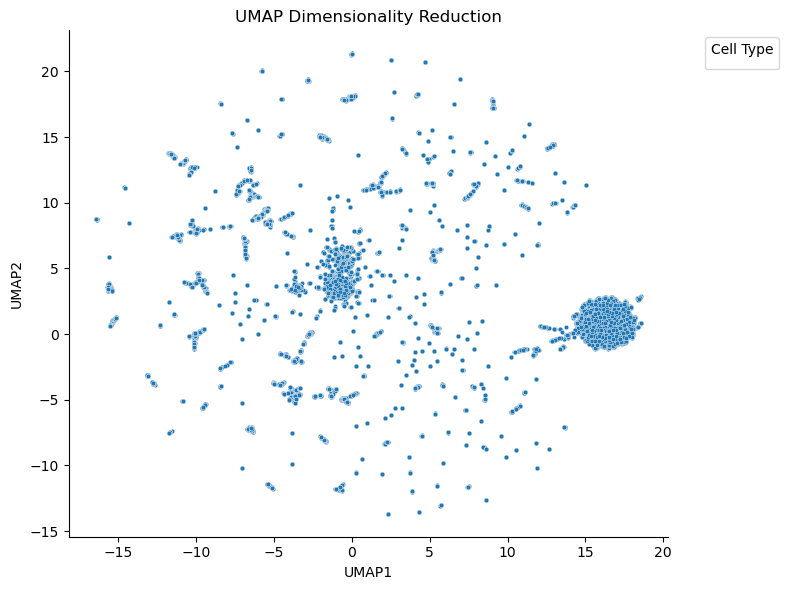

In [23]:
# Optional: You can add additional information from adata.obs for coloring
umap_df['TF'] = adata.obs['TF']  # Assuming 'cell_type' exists in adata.obs

# Step 3: Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df, palette='viridis', s=10)

# Customize plot
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine()
# Show plot
plt.show()


In [31]:
adata.obs['UMAP1'] = list(umap_df['UMAP1'].values)
adata.obs['UMAP2'] = list(umap_df['UMAP2'].values)
adata.obs

,TF,U,n_counts_UMIs,UMAP1,UMAP2
0,NaN,0.00,1013214.0,16.412729,0.395593
1,ENSG00000137203,-1.00,1013214.0,17.312416,1.833096
2,ENSG00000137203,-0.75,1013214.0,16.947084,-0.281493
3,ENSG00000137203,-0.50,1013214.0,15.754408,0.702132
4,ENSG00000137203,-0.25,1013214.0,16.106817,1.959148
...,...,...,...,...,...
16366,ENSG00000136936,0.50,1031819.0,0.230964,1.289263
16367,ENSG00000136936,0.75,1041121.5,0.229659,1.290687
16368,ENSG00000136936,1.00,1050424.0,0.231797,1.286656
16369,ENSG00000136936,1.25,1059726.5,0.230243,1.290196


In [ ]:
# Step 3: Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=adata.obs,
    x='UMAP1',
    y='UMAP2',
    palette='viridis',
    edgecolor=None,
    hue='U',
    style='TF',
    s=10
)
plt.yticks([])
plt.xticks([])
# Customize plot
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Magnitude', bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor='k')
sns.despine()
plt.tight_layout()
plt.show()


In [39]:
adata.obs['U'].unique()

array([ 0.  , -1.  , -0.75, -0.5 , -0.25,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ])